# Set up the environment
## Install and import packages
The following cells install certain required packages and components into your virtual environment for working through each of the steps in this particular programme. 
Read the comments (any text that follows "#") for details of each line. The comments will also contain details of what elements can be changed for your individual use case where applicable.

If the packages and modules are already installed and configured correctly in the virtual environment from previous workbooks, the workbook will automatically skip over these packages when the cells are run. 

In [ ]:
# Install required packages
! pip install -r ../requirements.txt

In [2]:
# This workbook uses the following modules. A short description of the purpose of the package is included for reference.

# The first time you run this cell, the workbook will download and configure the different models, libraries, and components onto your working environment. Depending on your Internet connection speed, this may take several minutes. Before running this cell, consider battery life, memory capacity, and bandwidth.

# Import required modules
import pandas as pd # This module is used for working with datasets
import json # This module encodes and decodes JSON objects
import pprint # This module prints datastructures in a more human-readable way
# The following modules are used for text classification
from transformers import pipeline # This module is used for working with transformer models
import torch # This module accelerates machine learning operations
from transformers import BertTokenizerFast, BertForTokenClassification # This module is used for text classification
# The following modules are used for representing data.
import matplotlib.pyplot as plt # This module is used for plotting graphs
import seaborn as sns # This module is used for plotting graphs

## Set classifier
The following cells configure the specific text classifiers used later in this notebook. 
The text classification model ['bias-type-classifier'](https://huggingface.co/maximuspowers/bias-type-classifier) makes predictions about bias types present in texts. 
The subsequent tokenizer model ['social-bias-ner'](https://huggingface.co/ethical-spectacle/social-bias-ner) performs granular, multi-label token classification of generalizations, unfairness, and stereotypes. 

The classification model in both pipelines uses a ber-base-uncased text classification model fine-tuned on the [GUS dataset](https://huggingface.co/datasets/ethical-spectacle/gus-dataset-v1) as part of the [GUS-Net project](https://huggingface.co/spaces/ethical-spectacle/gusnet-v1-demo). The [GUS-Net: Social Bias NER toolkit](https://huggingface.co/collections/maximuspowers/gus-net-social-bias-ner-685f3eb04a8c3fb9e706cb96) is available from [Ethical Spectacle](https://ethicalspectacle.org).

The pipeline downloads the pre-trained models from [Hugging Face](https://huggingface.co/huggingface), an open-source platform and community for NLP and AI tasks and research. 

Warning: [This paper](https://arxiv.org/abs/2410.08388) and the training dataset contains examples of harmful language, and reader discretion is recommended.

In [74]:
# The first time you run this cell, the pipeline may download and configure more components into the working environment. Depending on Internet connection speed, this may take several minutes. Before running this cell, consider battery life, memory capacity, and bandwidth.

# Create the text-classification pipeline using your specified model
classifier = pipeline(
    "text-classification",
    model="maximuspowers/bias-type-classifier", # Change the model used for text classification
    top_k=None # this parameter shows scores across all measured categories, change the value to an integer to return the score for only a certain subset of n scores
)

Device set to use mps:0


In [6]:
# The first time you run this cell, the pipeline may download and configure more components into the working environment. Depending on Internet connection speed, this may take several minutes. Before running this cell, consider battery life, memory capacity, and bandwidth.

# Define the tokenized entity classification pipeline
# Initialize required components.
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = BertForTokenClassification.from_pretrained('ethical-spectacle/social-bias-ner') 
model.eval()
model.to('cuda' if torch.cuda.is_available() else 'cpu')

# ids to labels we want to display
id2label = {
    0: 'O',
    1: 'B-STEREO',
    2: 'I-STEREO',
    3: 'B-GEN',
    4: 'I-GEN',
    5: 'B-UNFAIR',
    6: 'I-UNFAIR'
}

# Define the predict function using the above defined transformers and classifiers
def predict_ner_tags(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128)
    input_ids = inputs['input_ids'].to(model.device)
    attention_mask = inputs['attention_mask'].to(model.device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.sigmoid(logits)
        predicted_labels = (probabilities > 0.5).int() # adjust the threshold probabilities

    result = []
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    for i, token in enumerate(tokens):
        if token not in tokenizer.all_special_tokens:
            label_indices = (predicted_labels[0][i] == 1).nonzero(as_tuple=False).squeeze(-1)
            labels = [id2label[idx.item()] for idx in label_indices] if label_indices.numel() > 0 else ['O']
            result.append({"token": token, "labels": labels})

    return json.dumps(result, indent=4)


## Create the dataframe
Previous workbooks in this application save data generated data and analysis into the 'outputs' directory. The cell below creates a dataframe from a file generated and saved in the proceeding workbook ('outputs/textSentiment.csv'). However, the analysis in this workbook does not require quantitative data  generated by the steps in any previous workbooks. The cells below perform analysis with any text, regardless of its source. 

In [ ]:
# use pandas to read a CSV file
df = pd.read_csv('../outputs/debias.csv')  # replace 'outputs/debias.csv' with your actual file path
df.head()

,museum_reference,title,description,date,style_culture,image,interpretation,GenAIinterpretation,tokens_used,wordCount,...,GenAIvadarNeu,GenAIvadarCompound,countTermsDetected,terms,issues,sources,genAIcountTermsDetected,genAIterms,genAIissues,genAIsources
0,A.1911.397.243,Firestick,"Firestick, wood with a reed sheath decorated w...",19th - 20th century,Australian Aboriginal,A.1911.397.243.png,A common method for making fire was to rub two...,"Firesticks such as this, with a reed sheath an...",1258,29,...,0.806,0.8020,0,['No issues detected'],['No issues detected'],['No issues detected'],1,['Aboriginal'],['‘Aboriginal’ describes the original inhabita...,"['Tropen Museum et al., eds., “Words Matter: A..."
1,A.1898.372.39,Vessel,"Vessel (coolamon), roughly elliptical with rai...",19th century,Australian Aboriginal,A.1898.372.39.png,Coolamon are wooden dishes moulded over a fire...,"This coolamon, an elliptical wooden vessel fro...",1273,25,...,1.000,0.0000,0,['No issues detected'],['No issues detected'],['No issues detected'],1,['Aboriginal'],['‘Aboriginal’ describes the original inhabita...,"['Tropen Museum et al., eds., “Words Matter: A..."
2,A.1911.397.159,Bag,"String bag (dilly-bag), plant fibre: Australas...",19th - 20th century,Australian Aboriginal,A.1911.397.159.png,"Across Australia's Northern Territory, Aborigi...","Woven from plant fibres, this Australian Abori...",1258,49,...,0.969,0.2263,1,['Aboriginal'],['‘Aboriginal’ describes the original inhabita...,"['Tropen Museum et al., eds., “Words Matter: A...",1,['Aboriginal'],['‘Aboriginal’ describes the original inhabita...,"['Tropen Museum et al., eds., “Words Matter: A..."
3,K.2002.825,Basket,"Basket, bicornual with handle, cane plant: Aus...",19th century,Australian Aboriginal,K.2002.825.png,Crescent-shaped cane baskets were unique to th...,"Handwoven from cane plant, this bicornual bask...",1250,48,...,0.926,0.5859,0,['No issues detected'],['No issues detected'],['No issues detected'],1,['Aboriginal'],['‘Aboriginal’ describes the original inhabita...,"['Tropen Museum et al., eds., “Words Matter: A..."
4,V.2008.25,Basket,"Basket with black, red and yellow strips runni...",c. 2007,Pitjantjatjara,V.2008.25.png,Colourful coiled baskets are popular tourist i...,"Woven by Alison (Milyika) Carroll in 2007, thi...",1290,48,...,0.909,0.7184,1,['Aboriginal'],['‘Aboriginal’ describes the original inhabita...,"['Tropen Museum et al., eds., “Words Matter: A...",2,"['Aboriginal', 'Aboriginal']",['‘Aboriginal’ describes the original inhabita...,"['Tropen Museum et al., eds., “Words Matter: A..."


## Test the text classifier configuration
Previous cells configured the classification models and installed the required components. A successful test in the next cell will show how the text classifier returns results.

The first pipeline classifies text and returns an aggregate score for bias across pre-defined categories. The second pipeline granularly labels individual biased entities within text. Both are included here for users' interest and further investigation, but only the bias scores are included in the research and analysis.

In [ ]:
# Test the text-classification pipeline with a sample text

# Define the sample text
text = df['GenAIinterpretation'][0] # replace 0 with the index of the text you want to analyze

# Run the classifier on your example text
result = classifier(text)

# Print the result
pprint.pprint(result) 

[[{'label': 'racial', 'score': 0.9626227021217346},
  {'label': 'nationality', 'score': 0.03414846956729889},
  {'label': 'socioeconomic', 'score': 0.002313737291842699},
  {'label': 'religious', 'score': 0.0003455591795500368},
  {'label': 'political', 'score': 0.0001407465897500515},
  {'label': 'physical', 'score': 0.00011265387001913041},
  {'label': 'educational', 'score': 0.00010032398131443188},
  {'label': 'gender', 'score': 7.678437395952642e-05},
  {'label': 'sexuality', 'score': 5.616245107376017e-05},
  {'label': 'age', 'score': 4.240973430569284e-05},
  {'label': 'disability', 'score': 4.043093213113025e-05}]]


The follwoing pipeline classifies each token as one of the following: 
* Generalisations (GEN)
* Unfairness (UNFAIR)
* Stereotypes (STEREO)
* Neutral (0)

Then classifies each annotation into one of multiple semantic parts-of-speech categories:
* Beginning (B)
* Inside (I)
* Outside (O)

For example, the following label:
```
{
    "token": "women",
    "labels": [
        "B-STEREO",
        "B-GEN"
    ]
}
```
Identifies the word "women" as both a stereotype and a generalisation at the beginning of the sentence in which it is contextualised. 

Depending on the length of the sample text being analysed, the output may exceed the default display dimensions for the notebook. Convert the output to a scrollable element or view the results in a text editor using the hyperlinks displayed below the truncated output.

In [76]:
# Test the tokenized entity classification pipeline with a sample text
result = predict_ner_tags(text)

print(result)



[
    {
        "token": "fires",
        "labels": [
            "O"
        ]
    },
    {
        "token": "##tick",
        "labels": [
            "O"
        ]
    },
    {
        "token": "##s",
        "labels": [
            "O"
        ]
    },
    {
        "token": "such",
        "labels": [
            "O"
        ]
    },
    {
        "token": "as",
        "labels": [
            "O"
        ]
    },
    {
        "token": "this",
        "labels": [
            "O"
        ]
    },
    {
        "token": ",",
        "labels": [
            "O"
        ]
    },
    {
        "token": "with",
        "labels": [
            "O"
        ]
    },
    {
        "token": "a",
        "labels": [
            "O"
        ]
    },
    {
        "token": "reed",
        "labels": [
            "O"
        ]
    },
    {
        "token": "sheath",
        "labels": [
            "O"
        ]
    },
    {
        "token": "and",
        "labels": [
            "O"
        ]
  

# Use the Bias Type Classifier
The following cell classifies interpretive text produced by the museum and produced by Generative AI using the bias type classifier model and then saves the response alongside the collection metadata and interpretation in a dataframe for further analysis.

In [ ]:
# Calculate the bias probability scores for each text in the dataframe using the bias type classifier model

# Create lists to store the results of bias type classification
racialBias = []
religiousBias = []
genderBias = []
ageBias = []
nationalityBias = []
sexualityBias = []
socioeconomicBias = []
educationalBias = []
disabilityBias = []
politicalBias = []
physicalBias = []
genAIracialBias = []
genAIreligiousBias = []
genAIgenderBias = []
genAIageBias = []
genAInationalityBias = []
genAIsexualityBias = []
genAIsocioeconomicBias = []
genAIeducationalBias = []
genAIdisabilityBias = []
genAIpoliticalBias = []
genAIphysicalBias = []

# Use the text classifer to analyse interpretive texts 
for index, row in df.iterrows():
    # Define texts
    text = row['interpretation']
    genAItext = row['GenAIinterpretation']
    
    # Run the classifier on the museum generated texts
    result = classifier(text)
    
    # Extract the scores for each bias type from the response and append to the respective lists
    racialBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'racial'),
            0.0
        )
    )
    religiousBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'religious'),
            0.0
        )
    )
    genderBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'gender'),
            0.0
        )
    )
    ageBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'age'),
            0.0
        )
    )  
    nationalityBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'nationality'),
            0.0
        )
    )
    sexualityBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'sexuality'),
            0.0
        )
    )
    socioeconomicBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'socioeconomic'),
            0.0
        )
    )
    educationalBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'educational'),
            0.0
        )
    )
    disabilityBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'disability'),
            0.0
        )
    )
    politicalBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'political'),
            0.0
        )
    )
    physicalBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'physical'),
            0.0
        )
    )

    # Run the classifier on Generative AI texts
    result = classifier(genAItext)
    
    # Extract the scores for each bias type from the response and append to the respective lists
    genAIracialBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'racial'),
            0.0
        )
    )
    genAIreligiousBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'religious'),
            0.0
        )
    )
    genAIgenderBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'gender'),
            0.0
        )
    )
    genAIageBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'age'),
            0.0
        )
    )  
    genAInationalityBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'nationality'),
            0.0
        )
    )
    genAIsexualityBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'sexuality'),
            0.0
        )
    )
    genAIsocioeconomicBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'socioeconomic'),
            0.0
        )
    )
    genAIeducationalBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'educational'),
            0.0
        )
    )
    genAIdisabilityBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'disability'),
            0.0
        )
    )
    genAIpoliticalBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'political'),
            0.0
        )
    )
    genAIphysicalBias.append(
        next(
            (item['score'] for item in result[0] if item['label'] == 'physical'),
            0.0
        )
    )

# Add the responses to the dataframe
df['racialBias'] = racialBias
df['religiousBias'] = religiousBias
df['genderBias'] = genderBias
df['ageBias'] = ageBias
df['nationalityBias'] = nationalityBias
df['sexualityBias'] = sexualityBias
df['socioeconomicBias'] = socioeconomicBias
df['educationalBias'] = educationalBias
df['disabilityBias'] = disabilityBias
df['politicalBias'] = politicalBias
df['physicalBias'] = physicalBias
df['genAIracialBias'] = genAIracialBias
df['genAIreligiousBias'] = genAIreligiousBias
df['genAIgenderBias'] = genAIgenderBias
df['genAIageBias'] = genAIageBias
df['genAInationalityBias'] = genAInationalityBias
df['genAIsexualityBias'] = genAIsexualityBias
df['genAIsocioeconomicBias'] = genAIsocioeconomicBias
df['genAIeducationalBias'] = genAIeducationalBias
df['genAIdisabilityBias'] = genAIdisabilityBias
df['genAIpoliticalBias'] = genAIpoliticalBias
df['genAIphysicalBias'] = genAIphysicalBias

df.head() # The last columns of the dataframe contain the scores assigned by the classification model

# Save the dataframe
Dataframes work very well within the virtual environment for a wide variety of computational tasks, but they are not designed for long-term data storage or for sharing and distribution. The following cell takes the data from the dataframe and store it in a persistent file format.

After saving the results of the workbook with the following cell, users can close the workbook and resume subsequent analysis later by re-loading the data using the first cell in the next section. 

In [ ]:
# use pandas to write a CSV file
df.to_csv('../outputs/gusnet.csv', index=False)  # replace 'outputs/gusnet.csv' with the preferred file path

# Visualise the results
The following cells use different methods to produce statistical graphics and tables using the results from analysing the interpretive texts using the methods in this workbook. These elements can be used to explore further aspects of the data through quantitative analysis.

This section contains a cell that merges the dataframe containing the results generated by this workbook with a another table. The additional table outlines the relationship between the production style or culture, geographic region, and the exhibit with the World Cultures, Living Lands gallery.

Not all explorations will require aggregation along more general categories. Users should consider what kinds of questions they want to explore through these results and what data best answer those questions.

The following visualisations use the following functions. The full configuration instructions are available in the linked documentation for each function.

[Seaborn strip plot](https://seaborn.pydata.org/generated/seaborn.stripplot.html)

[Seaborn PairGrid](https://seaborn.pydata.org/generated/seaborn.PairGrid.html)

[Seaborn heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

In [3]:
# use pandas to read a CSV file
df_gusnet = pd.read_csv('../outputs/gusnet.csv')  # replace 'outputs/gusnet.csv' with your actual file path
df_gusnet.head()

,museum_reference,title,description,date,style_culture,image,interpretation,GenAIinterpretation,tokens_used,wordCount,...,genAIreligiousBias,genAIgenderBias,genAIageBias,genAInationalityBias,genAIsexualityBias,genAIsocioeconomicBias,genAIeducationalBias,genAIdisabilityBias,genAIpoliticalBias,genAIphysicalBias
0,A.1911.397.243,Firestick,"Firestick, wood with a reed sheath decorated w...",19th - 20th century,Australian Aboriginal,A.1911.397.243.png,A common method for making fire was to rub two...,"Firesticks such as this, with a reed sheath an...",1258,29,...,0.000346,0.000077,0.000042,0.034148,0.000056,0.002314,0.000100,0.000040,0.000141,0.000113
1,A.1898.372.39,Vessel,"Vessel (coolamon), roughly elliptical with rai...",19th century,Australian Aboriginal,A.1898.372.39.png,Coolamon are wooden dishes moulded over a fire...,"This coolamon, an elliptical wooden vessel fro...",1273,25,...,0.000462,0.000152,0.000066,0.244687,0.000082,0.001399,0.000318,0.000056,0.000402,0.000072
2,A.1911.397.159,Bag,"String bag (dilly-bag), plant fibre: Australas...",19th - 20th century,Australian Aboriginal,A.1911.397.159.png,"Across Australia's Northern Territory, Aborigi...","Woven from plant fibres, this Australian Abori...",1258,49,...,0.000266,0.000138,0.000046,0.925504,0.000114,0.002722,0.000140,0.000027,0.000407,0.000094
3,K.2002.825,Basket,"Basket, bicornual with handle, cane plant: Aus...",19th century,Australian Aboriginal,K.2002.825.png,Crescent-shaped cane baskets were unique to th...,"Handwoven from cane plant, this bicornual bask...",1250,48,...,0.000293,0.000156,0.000067,0.085647,0.000055,0.010513,0.000146,0.000062,0.000185,0.000107
4,V.2008.25,Basket,"Basket with black, red and yellow strips runni...",c. 2007,Pitjantjatjara,V.2008.25.png,Colourful coiled baskets are popular tourist i...,"Woven by Alison (Milyika) Carroll in 2007, thi...",1290,48,...,0.000210,0.000178,0.000037,0.033625,0.000100,0.000886,0.000103,0.000028,0.000294,0.000044


In [4]:
# This cell merges the dataframe containing the results obtained through this workbook with a dataframe containing the relationship between 'style_culture' and the exhibit

# Use pandas to read a CSV file
stylecutlure_geo_exhibit = pd.read_csv('../data/styleculture_geo_exhibit.csv')  # Replace 'data/styleculture_geo_exhibit.csv' with your actual file path

# Perform a merge on the two dataframes
df_gusnet_ext = df_gusnet.merge(
    stylecutlure_geo_exhibit,
    on = 'style_culture',
    how = 'left'
)
df_gusnet_ext.head() # The last two columns in the dataframe contain the merged data

,museum_reference,title,description,date,style_culture,image,interpretation,GenAIinterpretation,tokens_used,wordCount,...,genAIageBias,genAInationalityBias,genAIsexualityBias,genAIsocioeconomicBias,genAIeducationalBias,genAIdisabilityBias,genAIpoliticalBias,genAIphysicalBias,geography,exhibit
0,A.1911.397.243,Firestick,"Firestick, wood with a reed sheath decorated w...",19th - 20th century,Australian Aboriginal,A.1911.397.243.png,A common method for making fire was to rub two...,"Firesticks such as this, with a reed sheath an...",1258,29,...,0.000042,0.034148,0.000056,0.002314,0.000100,0.000040,0.000141,0.000113,Australia,Land of Dreamings
1,A.1898.372.39,Vessel,"Vessel (coolamon), roughly elliptical with rai...",19th century,Australian Aboriginal,A.1898.372.39.png,Coolamon are wooden dishes moulded over a fire...,"This coolamon, an elliptical wooden vessel fro...",1273,25,...,0.000066,0.244687,0.000082,0.001399,0.000318,0.000056,0.000402,0.000072,Australia,Land of Dreamings
2,A.1911.397.159,Bag,"String bag (dilly-bag), plant fibre: Australas...",19th - 20th century,Australian Aboriginal,A.1911.397.159.png,"Across Australia's Northern Territory, Aborigi...","Woven from plant fibres, this Australian Abori...",1258,49,...,0.000046,0.925504,0.000114,0.002722,0.000140,0.000027,0.000407,0.000094,Australia,Land of Dreamings
3,K.2002.825,Basket,"Basket, bicornual with handle, cane plant: Aus...",19th century,Australian Aboriginal,K.2002.825.png,Crescent-shaped cane baskets were unique to th...,"Handwoven from cane plant, this bicornual bask...",1250,48,...,0.000067,0.085647,0.000055,0.010513,0.000146,0.000062,0.000185,0.000107,Australia,Land of Dreamings
4,V.2008.25,Basket,"Basket with black, red and yellow strips runni...",c. 2007,Pitjantjatjara,V.2008.25.png,Colourful coiled baskets are popular tourist i...,"Woven by Alison (Milyika) Carroll in 2007, thi...",1290,48,...,0.000037,0.033625,0.000100,0.000886,0.000103,0.000028,0.000294,0.000044,Australia,Land of Dreamings


In [42]:
# Create a new dataframe including only the bias scores for museum-generated texts
df_bias_ext_mus = df_gusnet_ext[[
    'museum_reference',
    'style_culture',
    'geography',
    'exhibit',
    'racialBias',
    'religiousBias',
    'genderBias',
    'ageBias',
    'nationalityBias',
    'sexualityBias',
    'socioeconomicBias',
    'educationalBias',
    'disabilityBias',
    'politicalBias',
    'physicalBias',
    ]].copy()
# Rename certain columns for representation
df_bias_ext_mus.rename(
    columns={
    'racialBias': 'Racial',
    'religiousBias': 'Religious',
    'genderBias': 'Gender',
    'ageBias': 'Age',
    'nationalityBias': 'Nationality',
    'sexualityBias': 'Sexuality',
    'socioeconomicBias': 'Socioeconomic',
    'educationalBias': 'Educational',
    'disabilityBias': 'Disability',
    'politicalBias': 'Political',
    'physicalBias': 'Physical',
    }, inplace=True
)
df_bias_ext_mus.head()

,museum_reference,style_culture,geography,exhibit,Racial,Religious,Gender,Age,Nationality,Sexuality,Socioeconomic,Educational,Disability,Political,Physical
0,A.1911.397.243,Australian Aboriginal,Australia,Land of Dreamings,0.649308,0.150454,0.003768,0.002529,0.120531,0.001086,0.011752,0.001821,0.000707,0.001637,0.056408
1,A.1898.372.39,Australian Aboriginal,Australia,Land of Dreamings,0.012446,0.003881,0.001120,0.003156,0.012775,0.002001,0.113878,0.001093,0.002697,0.000776,0.846178
2,A.1911.397.159,Australian Aboriginal,Australia,Land of Dreamings,0.052624,0.000720,0.920499,0.000041,0.024848,0.000223,0.000489,0.000036,0.000058,0.000171,0.000292
3,K.2002.825,Australian Aboriginal,Australia,Land of Dreamings,0.000188,0.000082,0.986724,0.000019,0.012452,0.000056,0.000150,0.000032,0.000040,0.000021,0.000234
4,V.2008.25,Pitjantjatjara,Australia,Land of Dreamings,0.968046,0.000234,0.000254,0.000037,0.029075,0.000115,0.001778,0.000109,0.000042,0.000199,0.000110


In [43]:
# Create a new dataframe including only the bias scores for Generative AI texts
df_bias_ext_genAI = df_gusnet_ext[[
    'museum_reference',
    'style_culture',
    'geography',
    'exhibit',
    'genAIracialBias',
    'genAIreligiousBias',
    'genAIgenderBias',
    'genAIageBias',
    'genAInationalityBias',
    'genAIsexualityBias',
    'genAIsocioeconomicBias',
    'genAIeducationalBias',
    'genAIdisabilityBias',
    'genAIpoliticalBias',
    'genAIphysicalBias',
    ]].copy()
# Rename certain columns for representation
df_bias_ext_genAI.rename(
    columns={
    'genAIracialBias': 'Racial',
    'genAIreligiousBias': 'Religious',
    'genAIgenderBias': 'Gender',
    'genAIageBias': 'Age',
    'genAInationalityBias': 'Nationality',
    'genAIsexualityBias': 'Sexuality',
    'genAIsocioeconomicBias': 'Socioeconomic',
    'genAIeducationalBias': 'Educational',
    'genAIdisabilityBias': 'Disability',
    'genAIpoliticalBias': 'Political',
    'genAIphysicalBias': 'Physical',
    }, inplace=True
)
df_bias_ext_genAI.head()

,museum_reference,style_culture,geography,exhibit,Racial,Religious,Gender,Age,Nationality,Sexuality,Socioeconomic,Educational,Disability,Political,Physical
0,A.1911.397.243,Australian Aboriginal,Australia,Land of Dreamings,0.962623,0.000346,0.000077,0.000042,0.034148,0.000056,0.002314,0.000100,0.000040,0.000141,0.000113
1,A.1898.372.39,Australian Aboriginal,Australia,Land of Dreamings,0.752303,0.000462,0.000152,0.000066,0.244687,0.000082,0.001399,0.000318,0.000056,0.000402,0.000072
2,A.1911.397.159,Australian Aboriginal,Australia,Land of Dreamings,0.070542,0.000266,0.000138,0.000046,0.925504,0.000114,0.002722,0.000140,0.000027,0.000407,0.000094
3,K.2002.825,Australian Aboriginal,Australia,Land of Dreamings,0.902767,0.000293,0.000156,0.000067,0.085647,0.000055,0.010513,0.000146,0.000062,0.000185,0.000107
4,V.2008.25,Pitjantjatjara,Australia,Land of Dreamings,0.964495,0.000210,0.000178,0.000037,0.033625,0.000100,0.000886,0.000103,0.000028,0.000294,0.000044


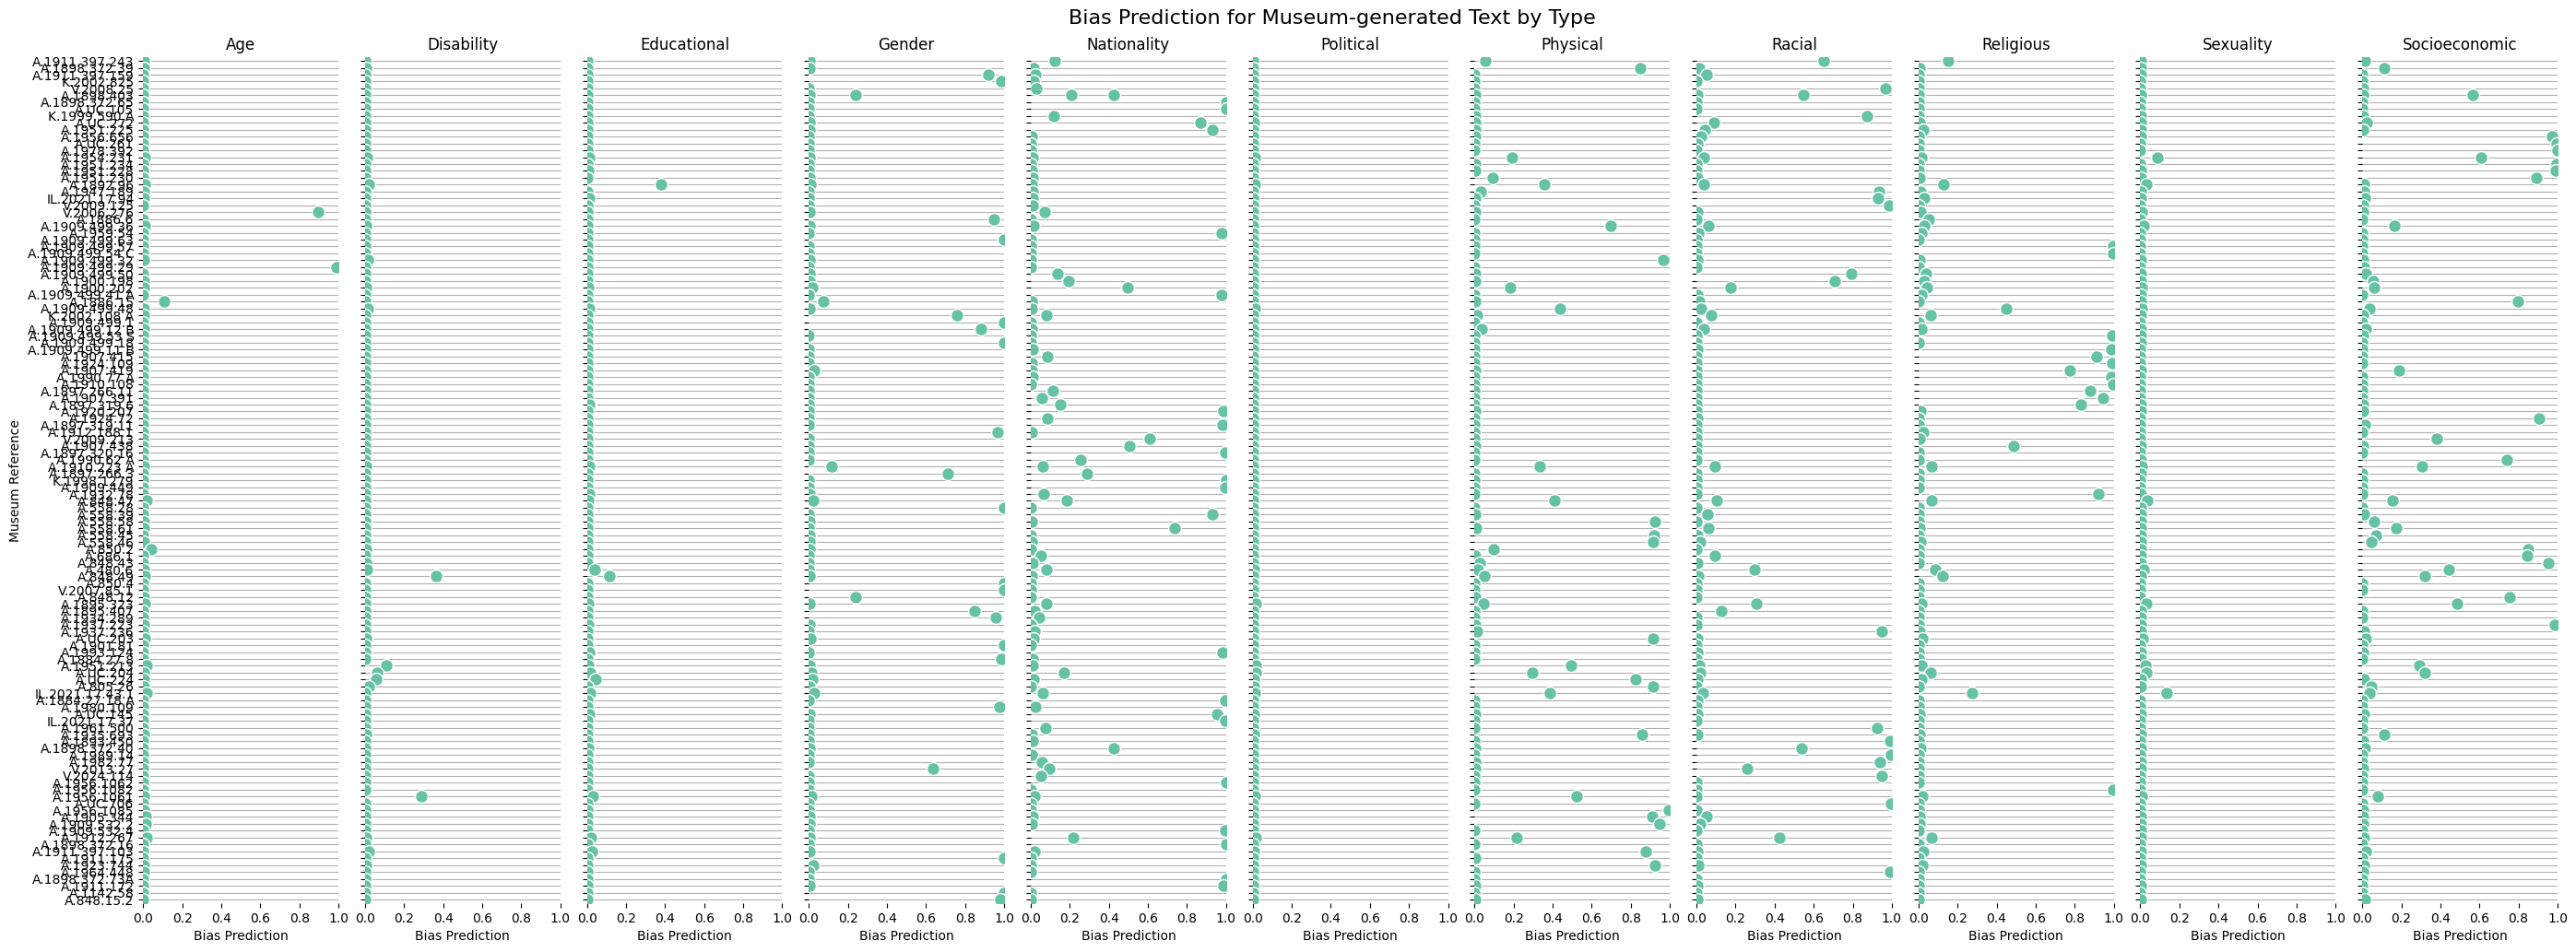

In [93]:
g = sns.PairGrid(
    df_bias_ext_mus,
    y_vars=["museum_reference"],
    x_vars=[
        'Age', 'Disability', 'Educational', 'Gender', 'Nationality', 'Political',
        'Physical', 'Racial', 'Religious', 'Sexuality', 'Socioeconomic',
    ],
    height=10,  
    aspect=0.25,
)

g.map(sns.stripplot, size=10, orient="h", jitter=False, color='#66c2a5', linewidth=1, edgecolor="w")  

g.set(xlim=(0, 1), xlabel="Bias Prediction", ylabel="Museum Reference")

titles = [
    'Age', 'Disability', 'Educational', 'Gender', 'Nationality', 'Political',
    'Physical', 'Racial', 'Religious', 'Sexuality', 'Socioeconomic',
]

for ax, title in zip(g.axes.flat, titles):
    ax.set(title=title)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

g.figure.suptitle(
    "Bias Prediction for Museum-generated Text by Type", 
    fontsize=16,
    y=1.03
)

sns.despine(left=True, bottom=True)


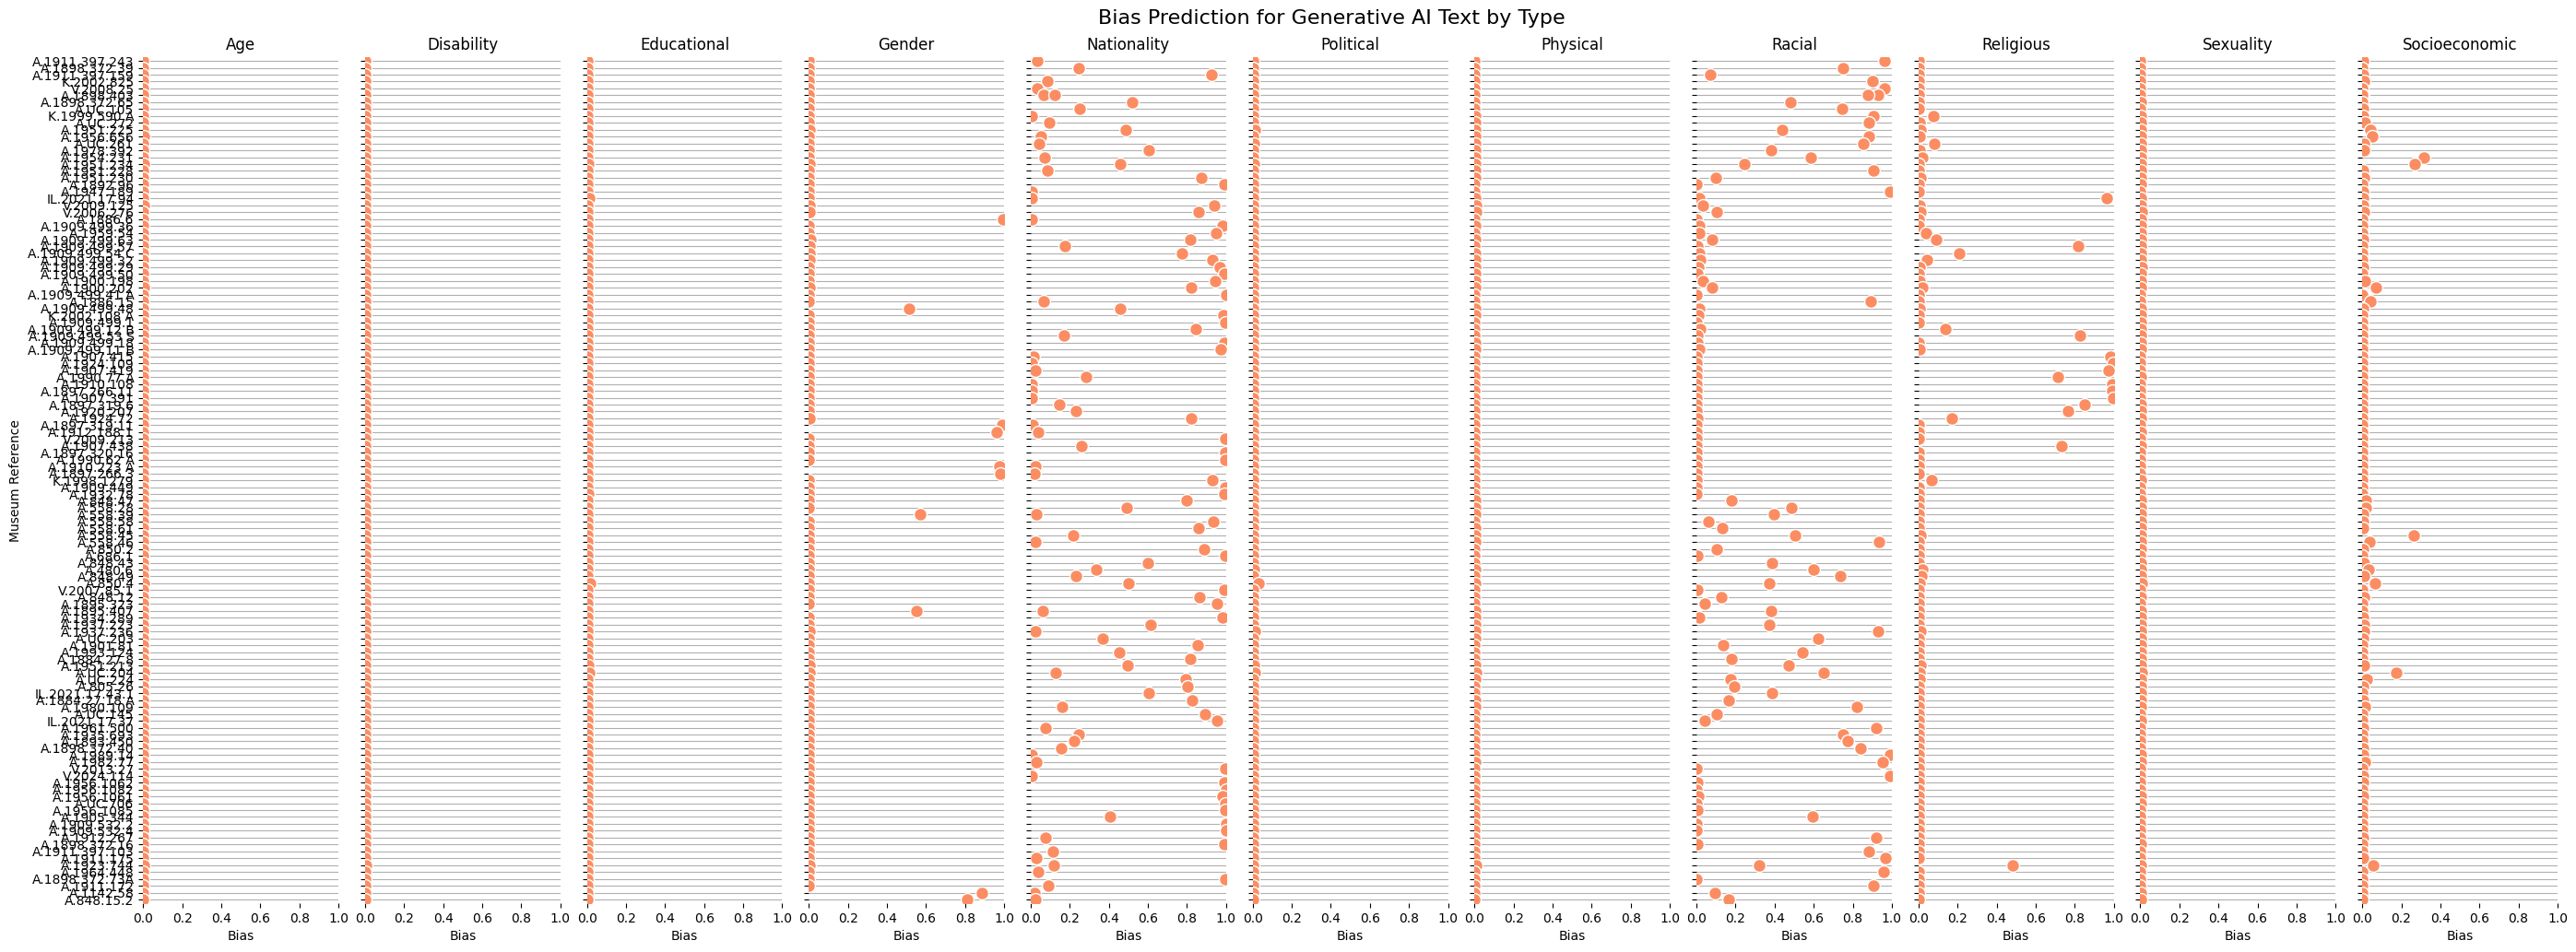

In [94]:
# Generative AI
# Compile a dot plot with several different variables
# Make the PairGrid
g = sns.PairGrid(
    df_bias_ext_genAI,
    y_vars=["museum_reference"],
    x_vars=[
    'Age',
    'Disability',
    'Educational',
    'Gender',
    'Nationality',
    'Political',
    'Physical', 
    'Racial',
    'Religious',
    'Sexuality',
    'Socioeconomic',  
    ],
    height=10,
    aspect=0.25,
)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      color='#fc8d62', linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 1), xlabel="Bias", ylabel="Museum Reference")

# Use semantically meaningful titles for the columns
titles = [
    'Age',
    'Disability',
    'Educational',
    'Gender',
    'Nationality',
    'Political',
    'Physical', 
    'Racial',
    'Religious',
    'Sexuality',
    'Socioeconomic',
]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

g.figure.suptitle("Bias Prediction for Generative AI Text by Type", fontsize=16,y=1.03)

sns.despine(left=True, bottom=True)

In [44]:
# This cell reshapes segments of the dataframe for specific graphical representations. It creates four new dataframes for representation and analysis.
df_bias_ext_mus_geo = pd.melt(
    df_bias_ext_mus,
    id_vars = [
        #'style_culture',
        'geography',
        #'exhibit'
    ],
    value_vars = [
    'Racial',
    'Religious',
    'Gender',
    'Age',
    'Nationality',
    'Sexuality',
    'Socioeconomic',
    'Educational',
    'Disability',
    'Political',
    'Physical',
    ],
    var_name = 'Label',
    value_name = 'Bias Score'
)
df_bias_ext_mus_exh = pd.melt(
    df_bias_ext_mus,
    id_vars = [
        #'style_culture',
        #'geography',
        'exhibit'
    ],
    value_vars = [
    'Racial',
    'Religious',
    'Gender',
    'Age',
    'Nationality',
    'Sexuality',
    'Socioeconomic',
    'Educational',
    'Disability',
    'Political',
    'Physical',
    ],
    var_name = 'Label',
    value_name = 'Bias Score'
)
df_bias_ext_genAI_geo = pd.melt(
    df_bias_ext_genAI,
    id_vars = [
        #'style_culture',
        'geography',
        #'exhibit'
    ],
    value_vars = [
    'Racial',
    'Religious',
    'Gender',
    'Age',
    'Nationality',
    'Sexuality',
    'Socioeconomic',
    'Educational',
    'Disability',
    'Political',
    'Physical',
    ],
    var_name = 'Label',
    value_name = 'Bias Score'
)
df_bias_ext_genAI_exh = pd.melt(
    df_bias_ext_genAI,
    id_vars = [
        #'style_culture',
        #'geography',
        'exhibit'
    ],
    value_vars = [
    'Racial',
    'Religious',
    'Gender',
    'Age',
    'Nationality',
    'Sexuality',
    'Socioeconomic',
    'Educational',
    'Disability',
    'Political',
    'Physical',
    ],
    var_name = 'Label',
    value_name = 'Bias Score'
)

In [45]:
# This cell incorporates data operations to the values across multiple entries within the dataframe.
df_bias_ext_mus_geo_hm = df_bias_ext_mus_geo.pivot_table( 
    index="geography", 
    columns="Label", 
    values="Bias Score")
df_bias_ext_mus_exh_hm = df_bias_ext_mus_exh.pivot_table( 
    index="exhibit", 
    columns="Label", 
    values="Bias Score")
df_bias_ext_genAI_geo_hm = df_bias_ext_genAI_geo.pivot_table( 
    index="geography", 
    columns="Label", 
    values="Bias Score")
df_bias_ext_genAI_exh_hm = df_bias_ext_genAI_exh.pivot_table( 
    index="exhibit", 
    columns="Label", 
    values="Bias Score")

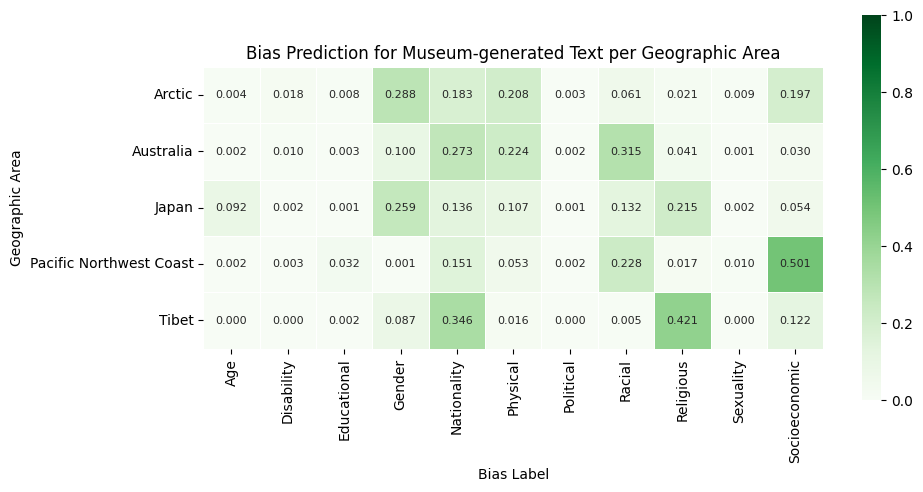

In [96]:
# Plot a heatmap to represent the bias prediction across each type for the geographic regions present in the gallery
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(
    df_bias_ext_mus_geo_hm, # Imports the dataset 
    square = True, # Ensures every cell is a square
    annot=True, # Represents cell values with text in the cell
    annot_kws={"fontsize":8}, # Adjust the font size for the annotations
    fmt=".3f", # Round value in annotation to 3 decimal places
    linewidth=0.5, # Adds lines between the cells
    vmin=0, # Sets datavalue for the minimum point on the colormap
    vmax=1, # Sets datavalue for the maximum point on the colormap
    cmap= "Greens" # Sets colormap by name
)
# The methods customize the figure which displays the chart.
ax.set_title('Bias Prediction for Museum-generated Text per Geographic Area')
ax.set_ylabel('Geographic Area')
ax.set_xlabel('Bias Label')
plt.show()

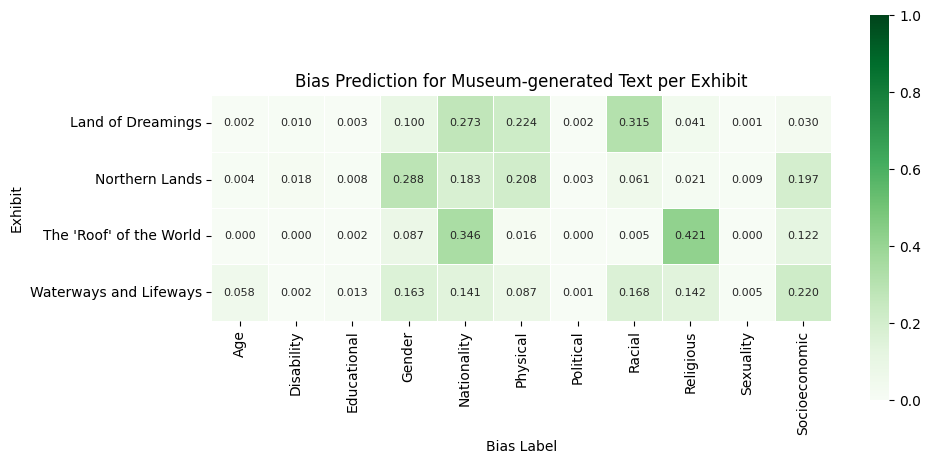

In [46]:
# Plot a heatmap to represent the bias prediction across each type for the exhibits present in the gallery
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(
    df_bias_ext_mus_exh_hm, # imports the dataset 
    square = True, # ensures every cell is a square
    annot=True, # represents cell values with text in the cell
    annot_kws={"fontsize":8}, # adjust the font size for the annotations
    fmt=".3f", # round value in annotation to 3 decimal places
    linewidth=0.5, # adds lines between the cells
    vmin=0, # sets datavalue for the minimum point on the colormap
    vmax=1, # sets datavalue for the maximum point on the colormap
    cmap= "Greens" # sets colormap by name
)
# The methods customize the figure which displays the chart.
ax.set_title('Bias Prediction for Museum-generated Text per Exhibit')
ax.set_ylabel('Exhibit')
ax.set_xlabel('Bias Label')
plt.show()

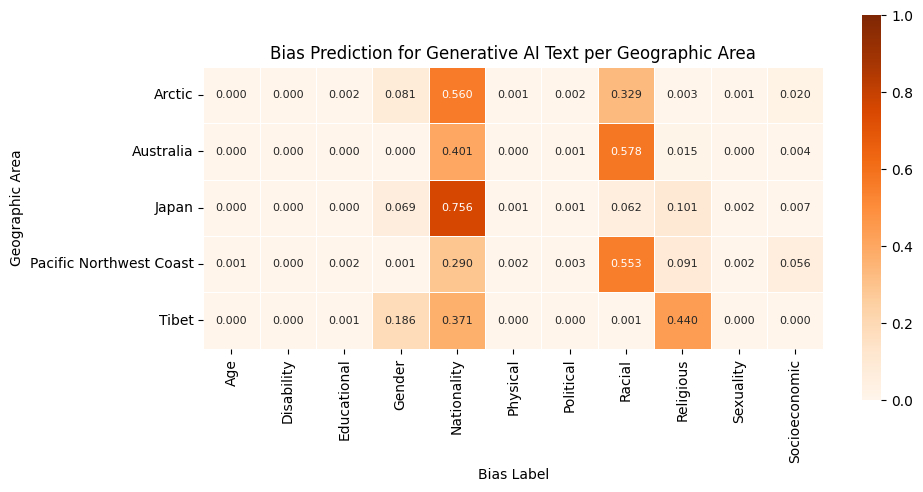

In [98]:
# Plot a heatmap to represent the bias prediction across each type for the geographic areas represented in the gallery
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(
    df_bias_ext_genAI_geo_hm, # imports the dataset 
    square = True, # ensures every cell is a square
    annot=True, # represents cell values with text in the cell
    annot_kws={"fontsize":8}, # adjust the font size for the annotations
    fmt=".3f", # round value in annotation to 3 decimal places
    linewidth=0.5, # adds lines between the cells
    vmin=0, # sets datavalue for the minimum point on the colormap
    vmax=1, # sets datavalue for the maximum point on the colormap
    cmap= "Oranges" # sets colormap by name
)
# The methods customize the figure which displays the chart.
ax.set_title('Bias Prediction for Generative AI Text per Geographic Area')
ax.set_ylabel('Geographic Area')
ax.set_xlabel('Bias Label')
plt.show()

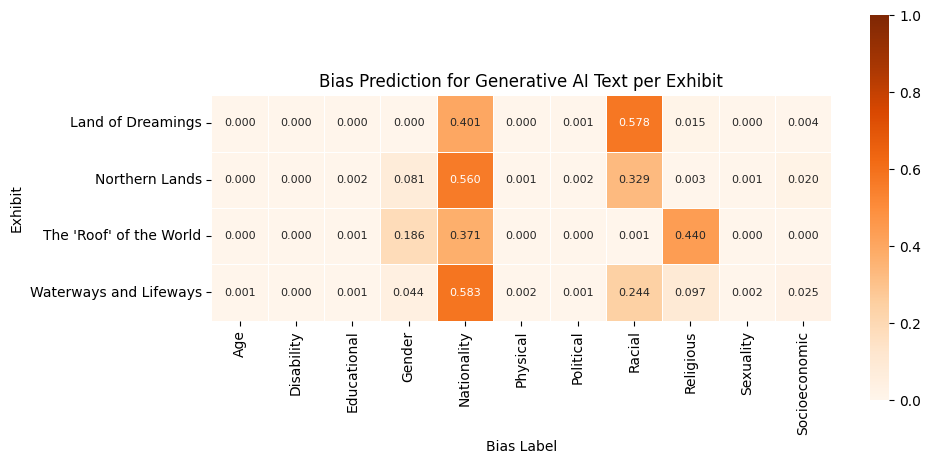

In [47]:
# Plot a heatmap to represent the bias prediction across each type for the exhibits present in the gallery
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.heatmap(
    df_bias_ext_genAI_exh_hm, # imports the dataset 
    square = True, # ensures every cell is a square
    annot=True, # represents cell values with text in the cell
    annot_kws={"fontsize":8}, # adjust the font size for the annotations
    fmt=".3f", # round value in annotation to 3 decimal places
    linewidth=0.5, # adds lines between the cells
    vmin=0, # sets datavalue for the minimum point on the colormap
    vmax=1, # sets datavalue for the maximum point on the colormap
    cmap= "Oranges" # sets colormap by name
)
# The methods customize the figure which displays the chart.
ax.set_title('Bias Prediction for Generative AI Text per Exhibit')
ax.set_ylabel('Exhibit')
ax.set_xlabel('Bias Label')
plt.show()

In [ ]:
# get the token-level bias tags for a specific object interpretation
museum_reference = 'A.1909.499.32'  # replace with the actual museum reference you want to analyze
source = 'interpretation' # specify the source of the interpretation, either 'interpretation' or 'GenAIinterpretation'

# find the index of the museum reference in the dataframe
index = df_gusnet[df_gusnet['museum_reference'] == museum_reference].index[0] if not df_gusnet[df_gusnet['museum_reference'] == museum_reference].empty else None
if index is not None:
    text = df_gusnet[source][index]  # retrieves the interpretation text for the specified museum reference
else:
    print(f"Museum reference '{museum_reference}' not found in the dataframe.")
result = predict_ner_tags(text) # returns the token-level bias tags for the museum-generated interpretation

# Export the results to a CSV file
export = pd.json_normalize(json.loads(result))
export.to_csv('../exports/'+museum_reference+'.csv', sep=',', index=False) # the results are exported to a CSV file with the museum reference as the filename in the 'exports' folder

Go to the Workbooks directory and open the workbook titled "5_debias.ipynb" to continue with the analysis.